## Table of Contents


- [Exploratory Data Analysis:](#exploratory)
After preprocessing the data, the next step is to explore it to gain insights. This can involve visualizing the data using graphs and charts, calculating summary statistics, and identifying patterns and trends in the data. This step can help in selecting the appropriate machine learning algorithm for the task.


### Exploratory Data Analysis <a id='exploratory'></a>
We already have a good dataset


In [1]:
from datetime import date,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

import matplotlib.pyplot as plt

# load the dataset
df = pd.read_csv('../Dataset/df_form_previous_step.csv')
df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
0,1,api,Support (T1),2840334,2017-08-04,Trial,Sunday,Tier 1,13.0,33861.0,18.0,36.0,0,NaN,2011-10-18,London,Employee,2117
1,1,email,Support (T1),2136496,2017-01-09,Unknown,Wednesday,Tier 1,58.0,73659.0,30.0,70.0,1,1.0,2011-10-18,London,Employee,1910
2,1,facebook,Support (Triage),3034987,2017-10-12,Professional,Friday,Triage,30.0,1741.0,6.0,15.0,0,NaN,2011-10-18,London,Employee,2186
3,1,email,Support (T1),2311824,2017-03-02,Unknown,Sunday,Tier 1,78.0,25654.0,5.0,15.0,0,NaN,2011-10-18,London,Employee,1962
4,1,email,Support (T1),2213615,2017-01-30,Professional,Friday,Tier 1,4.0,16266.0,8.0,17.0,0,0.0,2011-10-18,London,Employee,1931


### Data Preprocessing <a id='datapreprocessing'></a>

- Data Cleaning: The first step in data preprocessing is to clean the data by removing any errors or inconsistencies. This can involve removing duplicate records, correcting errors in the data, and handling missing values.

- Data Integration: This step involves combining data from multiple sources into a single dataset. This can be challenging if the data is stored in different formats or if the data has different structures.(We dont have this here)

- Data Transformation: Once the data has been cleaned and integrated, the next step is to transform the data into a format that is suitable for analysis. This can involve converting categorical data into numerical data, scaling or normalizing the data, or transforming the data to reduce skewness or outliers.

- Data Reduction: This step involves reducing the size of the dataset by selecting only the most relevant features (variables) for the analysis. This can help to reduce the computational complexity of the analysis and improve the performance of the machine learning model.

- Data Discretization: This step involves converting continuous variables into discrete variables by dividing them into intervals or categories. This can be useful for handling data that is not normally distributed or for creating categorical variables for use in machine learning models.

- Data Normalization: This step involves scaling the data so that it has a mean of zero and a standard deviation of one. This can help to ensure that the variables are on the same scale and prevent one variable from dominating the analysis.

- Data Sampling: This step involves selecting a subset of the data for analysis. This can be useful for handling large datasets or for balancing the dataset if there are imbalances between the classes or categories

## Data Cleaning

<Axes: >

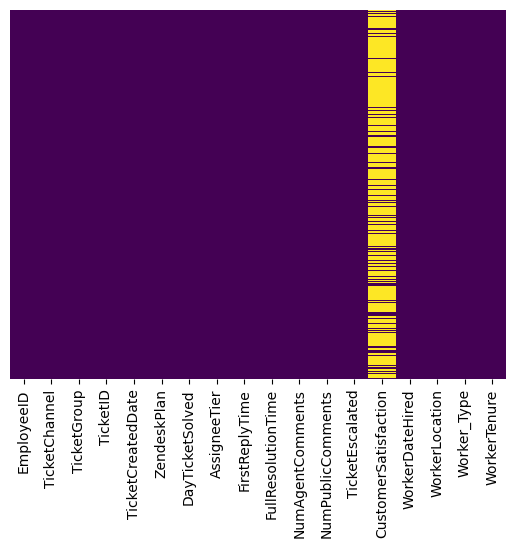

In [2]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<Axes: >

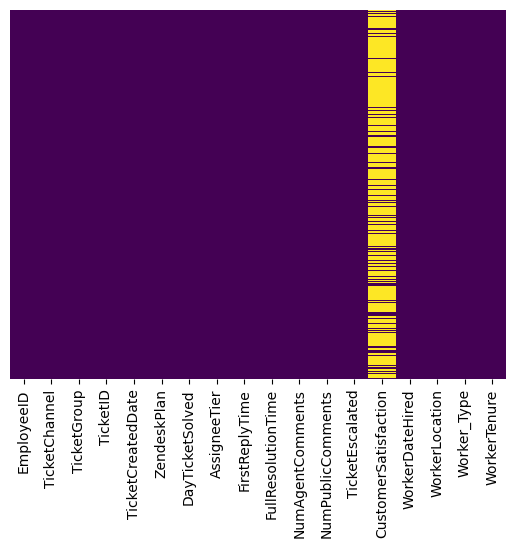

In [3]:
#Fill ZendeskPlan with the Unknown value that it already had
df.ZendeskPlan.fillna('Unknown', inplace=True)

# Calculate the median of each column
mean_first_reply_time = df['FirstReplyTime'].median()
mean_num_agent_comments = df['NumAgentComments'].median()
mean_num_public_comments = df['NumPublicComments'].median()
mean_first_FullResolutionTime = df['FullResolutionTime'].median()

# Fill missing values with the mean of each column
df['FullResolutionTime'] = df['FullResolutionTime'].fillna(mean_first_FullResolutionTime)
df['FirstReplyTime'] = df['FirstReplyTime'].fillna(mean_first_reply_time)
df['NumAgentComments'] = df['NumAgentComments'].fillna(mean_num_agent_comments)
df['NumPublicComments'] = df['NumPublicComments'].fillna(mean_num_public_comments)

#df["DayTicketSolved"].isnull().sum() has 924 records as null, because its low we can drop the rows
df.dropna(subset=['DayTicketSolved'], inplace=True)

#df["AssigneeTier"].isnull().sum() has 32655 nulls
# we need to fill this data and we are going to use mode() that returns the most frequent value
df['AssigneeTier'].fillna(df['AssigneeTier'].mode()[0], inplace=True)


#plot null values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Feature Engineering <a id='feature'></a>

This is where we are going transform, create and select the features to be used in the machine learning model.

- Feature Selection: Feature selection involves identifying the most relevant features for the machine learning model. This can involve techniques such as correlation analysis, principal component analysis (PCA), or feature importance ranking.
- Feature Extraction: Feature extraction involves creating new features by combining or transforming the existing features. This can involve techniques such as polynomial features, interaction terms, or dimensionality reduction.
- Feature Scaling: Feature scaling involves rescaling the features so that they have a similar scale. This can help to improve the performance of machine learning models and prevent one feature from dominating the analysis.
- Feature Validation: Feature validation involves testing the performance of the machine learning model using the new features. This can involve techniques such as cross-validation or hold-out validation.

First we are going to extract new information:
- Statistical data about the employee performance

In [4]:
#Add new features

# Convert TicketCreatedDate to datetime format
df['TicketCreatedDate'] = pd.to_datetime(df['TicketCreatedDate'])

# Create MonthCreated and MonthSolved columns
df['MonthCreated'] = df['TicketCreatedDate'].dt.to_period('M')

# Create a new column MonthSolved
df["TicketEndDate"] = df["TicketCreatedDate"] + pd.to_timedelta(df["FullResolutionTime"], unit='m')

# Extract the month from the MonthSolved column
df["MonthSolved"] = df["TicketEndDate"].dt.to_period('M')


# Generalize group of the ticket
df['TicketGroup_Group']=df['TicketGroup'].str.split('(').str[0]
# Define a function to categorize WorkerTenure
def categorize_tenure(tenure_days):
    tenure_months = round(tenure_days / 30.5)  # Convert days to months, rounding to nearest month
    if tenure_months <= 6:
        return "1-6 Months"
    elif tenure_months <= 12:
        return "7-12 Months"
    elif tenure_months <= 18:
        return "1 Year - 1 Year 6 Months"
    elif tenure_months <= 24:
        return "1 Year 7 Months - 2 Years"
    elif tenure_months <= 36:
        return "2 Year - 3 Years"
    elif tenure_months <= 48:
        return "3 Year - 4 Years"
    elif tenure_months <= 60:
        return "4 Year - 5 Years"
    else:
        return "More than 5 Years"

# Create new column WorkerTenure6Months
df["WorkerTenure6Months"] = df["WorkerTenure"].apply(categorize_tenure)

# Define the order of categories based on tenure months
cat_order = ["1-6 Months", "7-12 Months", "1 Year - 1 Year 6 Months", 
             "1 Year 7 Months - 2 Years", "2 Year - 3 Years", 
             "3 Year - 4 Years", "4 Year - 5 Years", "More than 5 Years"]

# Convert WorkerTenure6Months to categorical data type with the specified order
df["WorkerTenure6Months"] = pd.Categorical(df["WorkerTenure6Months"], categories=cat_order)


#Statistical Data about the employee

#Number of tickets each employee has for each date of ticketCreation 
df_count =df.groupby(['EmployeeID', 'TicketCreatedDate'])['TicketID'].count().reset_index().rename(columns={'TicketID': 'TicketsCreatedCount'})
df = pd.merge(df, df_count, on=['EmployeeID', 'TicketCreatedDate'], how='left')

#Number of tickets each employee has for each month
df_count =df.groupby(['EmployeeID', 'MonthCreated'])['TicketID'].count().reset_index().rename(columns={'TicketID': 'TicketsMonthCreatedCount'})
df = pd.merge(df, df_count, on=['EmployeeID', 'MonthCreated'], how='left')

#Mean time that took to full resolution time for each employee and for each date of ticketCreatedDate
df_count =df.groupby(['EmployeeID', 'TicketCreatedDate'])['FullResolutionTime'].mean().reset_index().rename(columns={'FullResolutionTime': 'FullResolutionTime_AVG_TickectCreatedDate'})
df = pd.merge(df, df_count, on=['EmployeeID', 'TicketCreatedDate'], how='left')

#Mean time that took to full resolution time for each employee and for each month
df_count =df.groupby(['EmployeeID', 'MonthCreated'])['FullResolutionTime'].mean().reset_index().rename(columns={'FullResolutionTime': 'FullResolutionTime_AVG_TickectMonthCreated'})
df = pd.merge(df, df_count, on=['EmployeeID', 'MonthCreated'], how='left')

df.head()

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,...,WorkerTenure,MonthCreated,TicketEndDate,MonthSolved,TicketGroup_Group,WorkerTenure6Months,TicketsCreatedCount,TicketsMonthCreatedCount,FullResolutionTime_AVG_TickectCreatedDate,FullResolutionTime_AVG_TickectMonthCreated
0,1,api,Support (T1),2840334,2017-08-04,Trial,Sunday,Tier 1,13.0,33861.0,...,2117,2017-08,2017-08-27 12:21:00,2017-08,Support,More than 5 Years,1,37,33861.000000,6789.486486
1,1,email,Support (T1),2136496,2017-01-09,Unknown,Wednesday,Tier 1,58.0,73659.0,...,1910,2017-01,2017-03-01 03:39:00,2017-03,Support,More than 5 Years,6,147,17450.333333,8048.435374
2,1,facebook,Support (Triage),3034987,2017-10-12,Professional,Friday,Triage,30.0,1741.0,...,2186,2017-10,2017-10-13 05:01:00,2017-10,Support,More than 5 Years,6,109,10483.833333,9566.394495
3,1,email,Support (T1),2311824,2017-03-02,Unknown,Sunday,Tier 1,78.0,25654.0,...,1962,2017-03,2017-03-19 19:34:00,2017-03,Support,More than 5 Years,11,250,9450.000000,6973.632000
4,1,email,Support (T1),2213615,2017-01-30,Professional,Friday,Tier 1,4.0,16266.0,...,1931,2017-01,2017-02-10 07:06:00,2017-02,Support,More than 5 Years,2,147,19666.500000,8048.435374


# Feature Selection
- Improve Model Accuracy
- Lower Computational Cost
- Easier to Understand & Explain

Whays:
- [Correlation Matrix:](#corr)

A correlation matrix is simply a table which displays the correlation coefficients for different variables.

- [Univariate Testing:](#univariate)


Univariate Feature Selection or Testing applies statistical tests to find relationships between the output variable and each input variable in isolation. Tests are conducted one input variable at a time. The tests depends whether you are running a regression task or a classification task.

Regression Task
In a regression task, you may be provided with an 
1. f-score ->  Is a measure of a model's accuracy that balances precision and recall. It is the harmonic mean of precision and recall.The F-score is particularly useful when dealing with imbalanced classes,
2. p-value -> Is a measure that avaluates the difference between two outcomes for example(the lower the better, and its used to prove the Null Hypothesis that is when we can be sure that the two groups are the same):
For example, let's say we want to test if there is a difference in the mean heights of two groups of people, group A and group B. The null hypothesis would be that the mean height of group A is equal to the mean height of group B. We can use a t-test to compute the p-value, and if the p-value is less than or equal to our level of significance (e.g. 0.05), we can reject the null hypothesis and conclude that there is a statistically significant difference in the mean heights of the two groups.


- [Recursive Feature Elimination with Cross-Validation (RFECV):](#rfecv)

RFE is popular because it is easy to configure and use and because it is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable



### Correlation Matrix: <a id='corr'></a>

In [5]:
#Scale data so i can use a person correlation algorithm

from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler object
scaler = StandardScaler()

# Scale the numerical columns in the DataFrame
df_scaled = scaler.fit_transform(df.select_dtypes(include='number'))

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.select_dtypes(include='number').columns)


# Concatenate the scaled data with the non-numerical columns
df_scaled = pd.concat([df_scaled, df.select_dtypes(exclude='number')], axis=1)


In [6]:
# Calculate Pearson correlation coefficient between all pairs of variables
corr_matrix = df_scaled.corr(method='pearson')

# Set up the heatmap figure
fig, ax = plt.subplots(figsize=(10,10))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)

# Set title
ax.set_title('Correlation Matrix')


ValueError: could not convert string to float: 'More than 5 Years'


### Univariate Testing: <a id='univariate'></a>


### Recursive Feature Elimination with Cross-Validation (RFECV): <a id='rfecv'></a>